In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy import interpolate
import matplotlib
matplotlib.rcParams['font.family']='Malgun Gothic'
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
forecast_weather = pd.read_csv('../../Data\\capstone\\weather/solar_forecast_weather.csv')
solar = pd.read_csv('../../Data\\capstone\\weather/solar_power_2204.csv')
real_weather = pd.read_csv('../../Data/capstone/total_eda_real.csv')
solar_2 = pd.read_csv('../../Data/capstone/발전소/하동_eda.csv')

In [4]:
def time_change(data, Forecast_time):
    """
    data = forecast가 있는 데이터
    Forecast_time = 예보시간

    return = 예보시간을 기준으로 데이터를 정렬한 데이터
    """
    data[Forecast_time] = pd.to_datetime(data[Forecast_time])
    data['real_time'] = data.apply(lambda row: row['Forecast time'] + datetime.timedelta(hours=row['forecast']), axis=1)
    forecast_weather_eda = data.groupby(['real_time']).mean().drop('forecast', axis=1)
    forecast_weather_eda.reset_index(inplace=True)
    return forecast_weather_eda

In [5]:
solar['datetime'] = pd.to_datetime(solar['datetime'])
solar.target.replace(65535.0, solar.target.mean(), inplace=True)
solar['month'] = solar.datetime.dt.month
solar['hour'] = solar.datetime.dt.hour
solar['year'] = solar.datetime.dt.year
solar['day'] = solar.datetime.dt.day
solar_eda = solar.groupby(['year','month','day','hour']).sum().reset_index()
solar_eda['date'] = pd.to_datetime(solar_eda[['year', 'month', 'day', 'hour']])

In [6]:
eda_forecast = time_change(forecast_weather, 'Forecast time')

In [7]:
reg = real_weather[real_weather['지점명'] =='순천']

In [8]:
eda_weather = reg.drop(['지점', '지점명'], axis=1)
eda_weather['일시'] = pd.to_datetime(eda_weather['일시'])
eda_weather['hour'] = eda_weather['일시'].dt.hour
eda_weather['month'] = eda_weather['일시'].dt.month
eda_weather['year'] = eda_weather['일시'].dt.year

In [9]:
eda_weather.set_index('일시', inplace=True)

In [10]:
total_time = pd.date_range(start='2021-01-01 00:00:00', end='2022-04-30 23:00:00', freq='H')

In [11]:
solar_2

,date,hour,value
0,2013-01-01 01:00:00,1,0.0
1,2013-01-01 02:00:00,2,0.0
2,2013-01-01 03:00:00,3,0.0
3,2013-01-01 04:00:00,4,0.0
4,2013-01-01 05:00:00,5,0.0
...,...,...,...
83227,2022-06-30 20:00:00,20,7.6
83228,2022-06-30 21:00:00,21,0.0
83229,2022-06-30 22:00:00,22,0.0
83230,2022-06-30 23:00:00,23,0.0


In [12]:
solar_2.date = pd.to_datetime(solar_2.date)

In [13]:
solar_2.set_index('date', inplace=True)

In [14]:
x = eda_weather.loc['2021-01-01 00:00:00' : '2022-04-30 23:00:00']

In [15]:
y = solar_2.loc['2021-01-01 00:00:00' : '2022-04-30 23:00:00']

In [16]:
y.drop('hour', axis=1 , inplace=True)

In [17]:
x.drop(['위도','경도'], axis=1, inplace=True)

In [18]:
total = pd.concat([x, y], axis = 1)

In [19]:
total.value = total.value/5

In [20]:
total.interpolate(method = 'linear', inplace = True)

In [21]:
y = total.value
x = total.drop('value', axis=1)

In [22]:
slice = 455 * 24

In [23]:
x_train = x.iloc[:slice]
x_test = x.iloc[slice:]
y_train = y.iloc[:slice]
y_test = y.iloc[slice:]

In [24]:
x_train_time = x.iloc[:slice]
x_test_time = x.iloc[slice:]
y_train_time = y.iloc[:slice]
y_test_time = y.iloc[slice:]

sc_x = StandardScaler()
sc_y = StandardScaler()

In [25]:
sc_x = MinMaxScaler()
sc_y = MinMaxScaler()

In [26]:
sc_x.fit(x_train)

x_train = sc_x.transform(x_train)
x_test = sc_x.transform(x_test)

In [27]:
sc_y.fit(y_train.values.reshape(-1,1))

y_train = sc_y.transform(y_train.values.reshape(-1,1))
y_train = y_train.flatten()

In [28]:
y_test = sc_y.transform(y_test.values.reshape(-1,1))

In [29]:
print(x_train.shape)
print(x_test.shape)

(10920, 8)
(720, 8)


----
# Auto Time series

In [30]:
from auto_ts import auto_timeseries

Imported auto_timeseries version:0.0.71. Call by using:
model = auto_timeseries(score_type='rmse',
        time_interval='M', non_seasonal_pdq=None, seasonality=False,
        seasonal_period=12, model_type=['best'], verbose=2, dask_xgboost_flag=0)
model.fit(traindata, ts_column,target)
model.predict(testdata, model='best')



In [31]:
model = auto_timeseries(
            score_type='rmse',
            time_interval='H',
            non_seasonal_pdq=None, seasonality=False,
            seasonal_period=12,
            model_type=['best'],
            verbose=2)

In [32]:
time_data = total.drop(['hour','month','year'], axis=1)

In [33]:
time_data.reset_index(inplace=True)

In [34]:
time_data_train = time_data.iloc[:slice]
time_data_test = time_data.iloc[slice:]

Start of Fit.....
    Target variable given as = value
Start of loading of data.....
    Inputs: ts_column = index, sep = ,, target = ['value']
    Using given input: pandas dataframe...
    index column exists in given train data...
    train data shape = (10920, 6)
Alert: Could not detect strf_time_format of index. Provide strf_time format during "setup" for better results.

Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Data is already stationary
There is no differencing needed in this datasets for VAR model


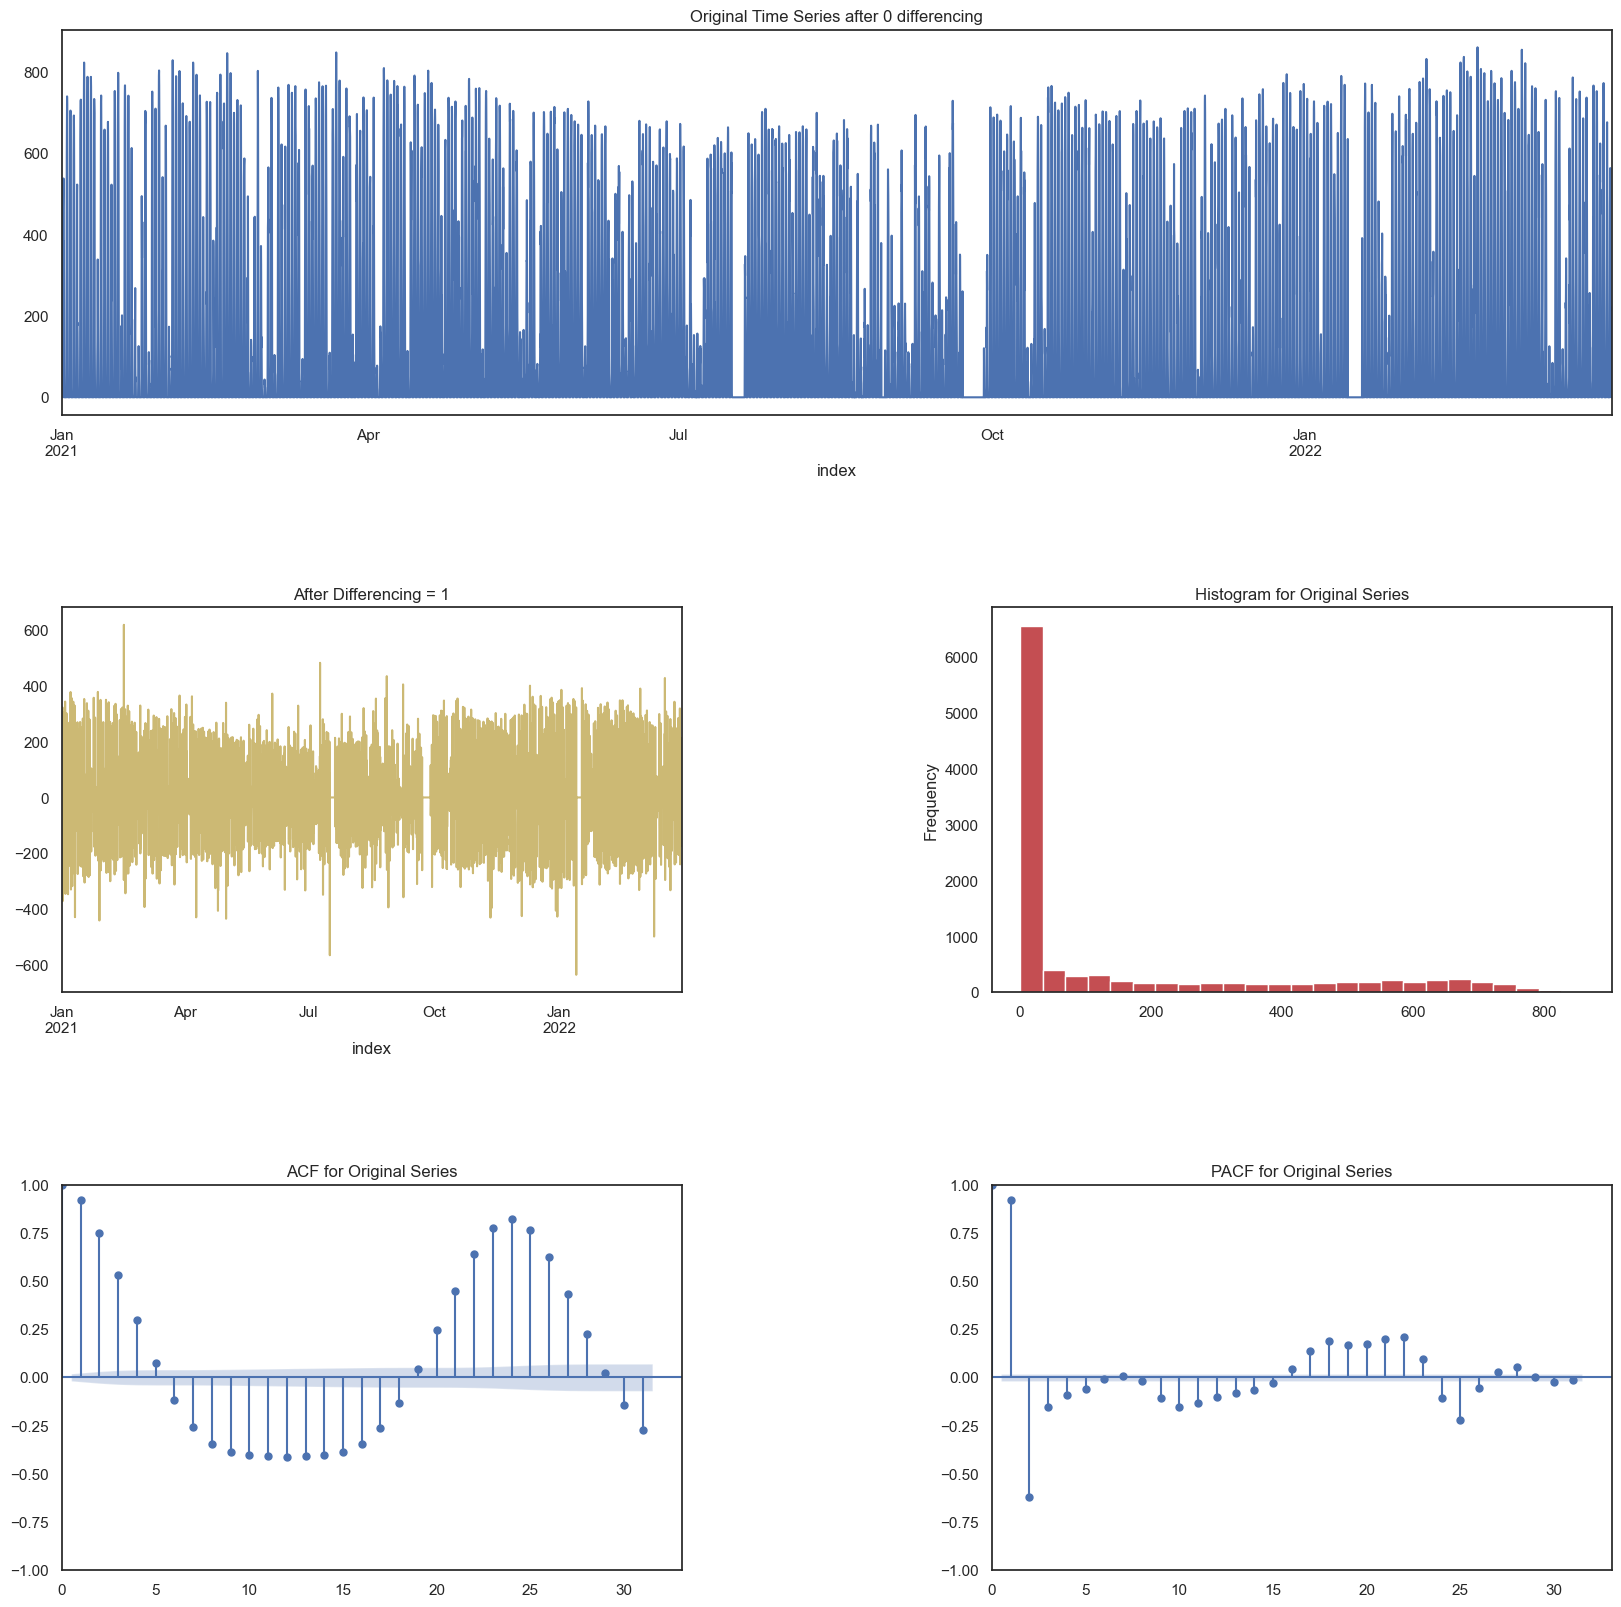

Time Interval is given as H
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...
kwargs for Prophet model: {'iter': 100}
    Fit-Predict data (shape=(10920, 7)) with Confidence Interval = 0.95...
  Starting Prophet Fit
      No seasonality assumed since seasonality flag is set to False
  Starting Prophet Cross Validation
Max. iterations using expanding window cross validation = 5

Fold Number: 1 --> Train Shape: 10895 Test Shape: 5


23:01:16 - cmdstanpy - INFO - Chain [1] start processing
23:01:16 - cmdstanpy - INFO - Chain [1] done processing


    RMSE = 31.80
    Std Deviation of actuals = 0.00
    Normalized RMSE (as pct of std dev) = inf%
Cross Validation window: 1 completed

Fold Number: 2 --> Train Shape: 10900 Test Shape: 5


23:01:18 - cmdstanpy - INFO - Chain [1] start processing
23:01:18 - cmdstanpy - INFO - Chain [1] done processing


    RMSE = 23.58
    Std Deviation of actuals = 41.24
    Normalized RMSE (as pct of std dev) = 57%
Cross Validation window: 2 completed

Fold Number: 3 --> Train Shape: 10905 Test Shape: 5


23:01:19 - cmdstanpy - INFO - Chain [1] start processing
23:01:20 - cmdstanpy - INFO - Chain [1] done processing


    RMSE = 77.30
    Std Deviation of actuals = 104.25
    Normalized RMSE (as pct of std dev) = 74%
Cross Validation window: 3 completed

Fold Number: 4 --> Train Shape: 10910 Test Shape: 5


23:01:21 - cmdstanpy - INFO - Chain [1] start processing
23:01:21 - cmdstanpy - INFO - Chain [1] done processing


    RMSE = 167.86
    Std Deviation of actuals = 78.49
    Normalized RMSE (as pct of std dev) = 214%
Cross Validation window: 4 completed

Fold Number: 5 --> Train Shape: 10915 Test Shape: 5


23:01:23 - cmdstanpy - INFO - Chain [1] start processing
23:01:23 - cmdstanpy - INFO - Chain [1] done processing


    RMSE = 23.17
    Std Deviation of actuals = 0.00
    Normalized RMSE (as pct of std dev) = inf%
Cross Validation window: 5 completed

-------------------------------------------
Model Cross Validation Results:
-------------------------------------------
    MAE (Mean Absolute Error = 54.82
    MSE (Mean Squared Error = 7251.19
    MAPE (Mean Absolute Percent Error) = inf%
    RMSE (Root Mean Squared Error) = 85.1539
    Normalized RMSE (MinMax) = 15%
    Normalized RMSE (as Std Dev of Actuals)= 45%
Time Taken = 9 seconds


23:01:25 - cmdstanpy - INFO - Chain [1] start processing
23:01:25 - cmdstanpy - INFO - Chain [1] done processing


  End of Prophet Fit


Building Auto SARIMAX Model



Running Auto SARIMAX Model...


Best Parameters:
p: None, d: None, q: None
P: None, D: None, Q: None
Seasonality: False
Seasonal Period: 12

Fold Number: 1 --> Train Shape: 10895 Test Shape: 5

    Finding the best parameters using AutoArima:
    Using smaller parameters for larger dataset with greater than 1000 samples

Best model is a Seasonal SARIMAX(2,0,2)*(0,0,0,12), aic = 123962.329
Static Forecasts:
    RMSE = 95.06
    Std Deviation of Actuals = 0.00
    Normalized RMSE (as pct of std dev) = inf%

Fold Number: 2 --> Train Shape: 10900 Test Shape: 5

    Finding the best parameters using AutoArima:
    Using smaller parameters for larger dataset with greater than 1000 samples

Best model is a Seasonal SARIMAX(2,0,2)*(0,0,0,12), aic = 124014.807
Static Forecasts:
    RMSE = 94.80
    Std Deviation of Actuals = 41.24
    Normalized RMSE (as pct of std dev) = 229.9%

Fold Number: 3 --> Train Shape: 10905 Test Shape: 5

    Findi

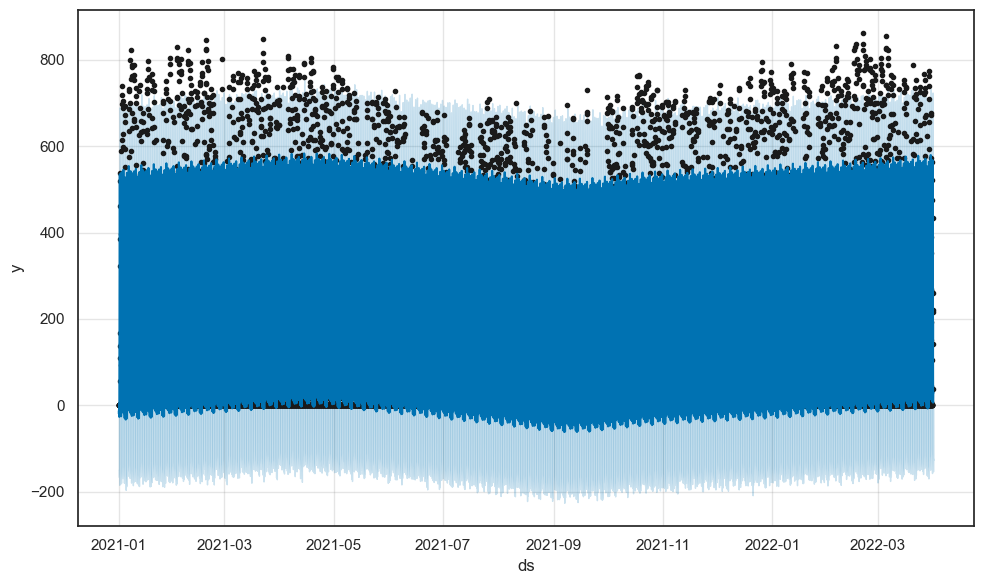

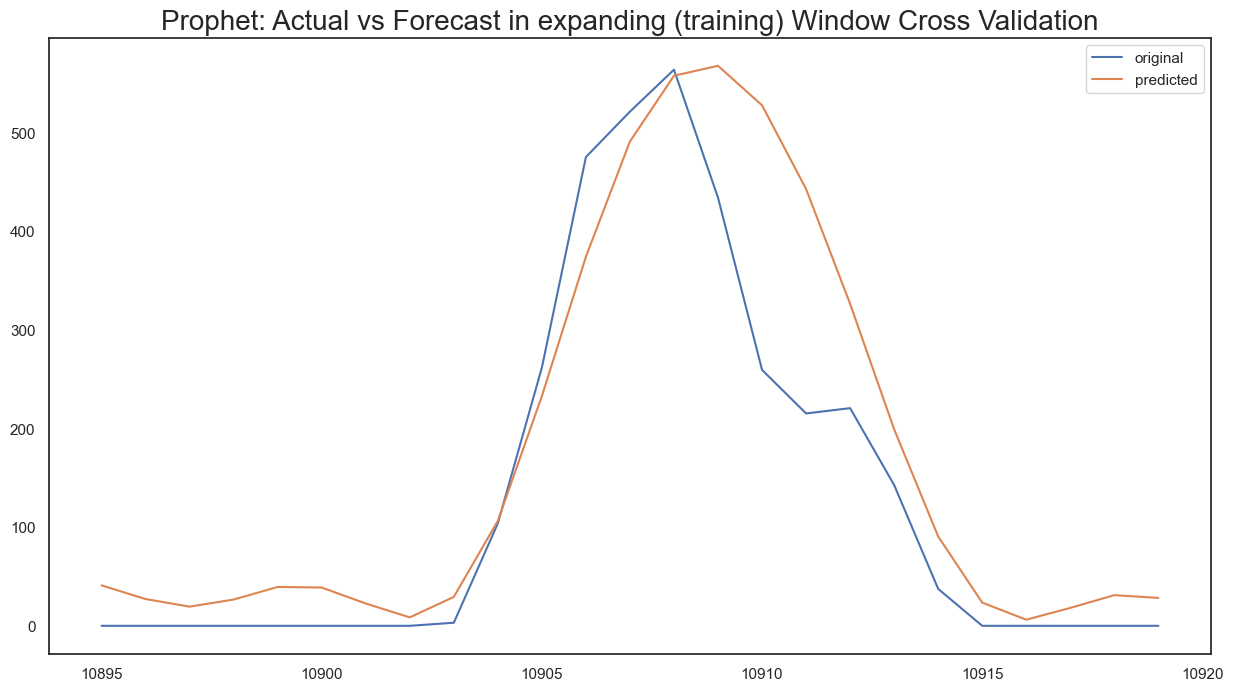

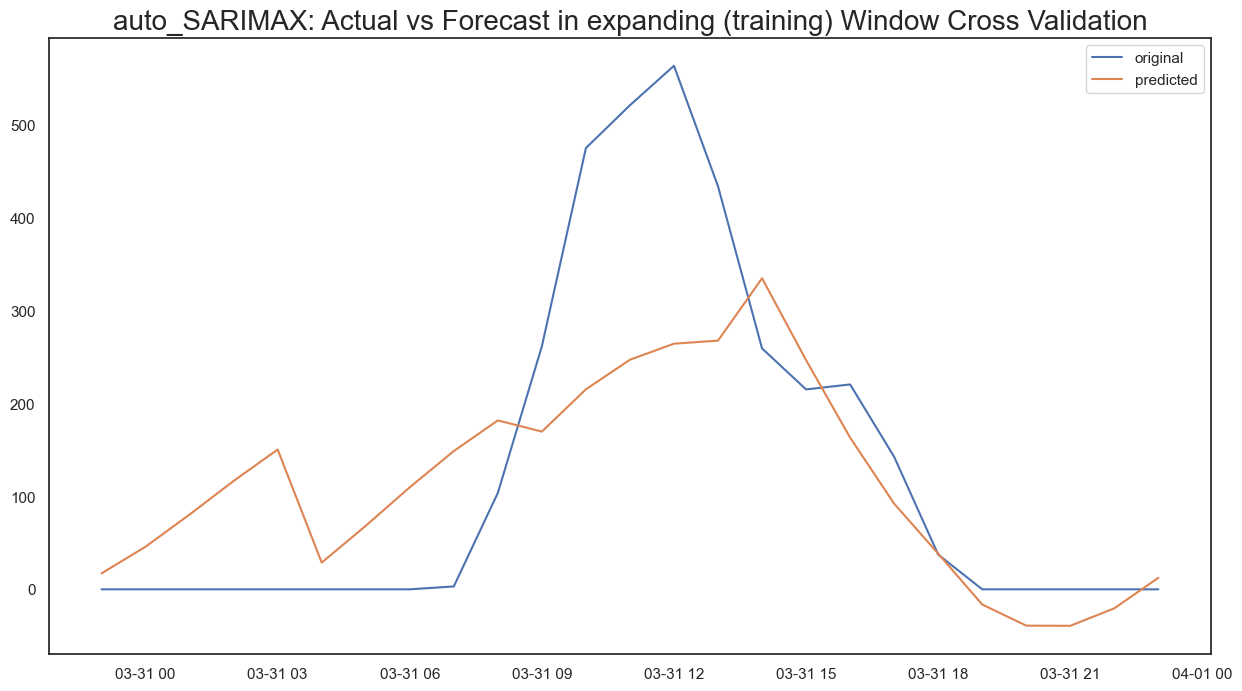

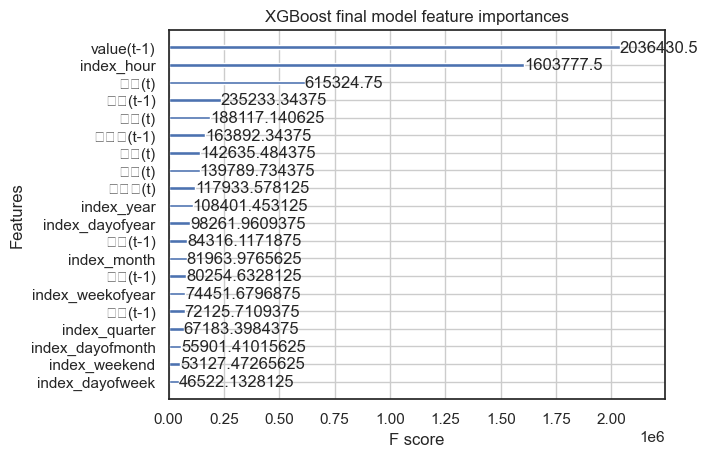

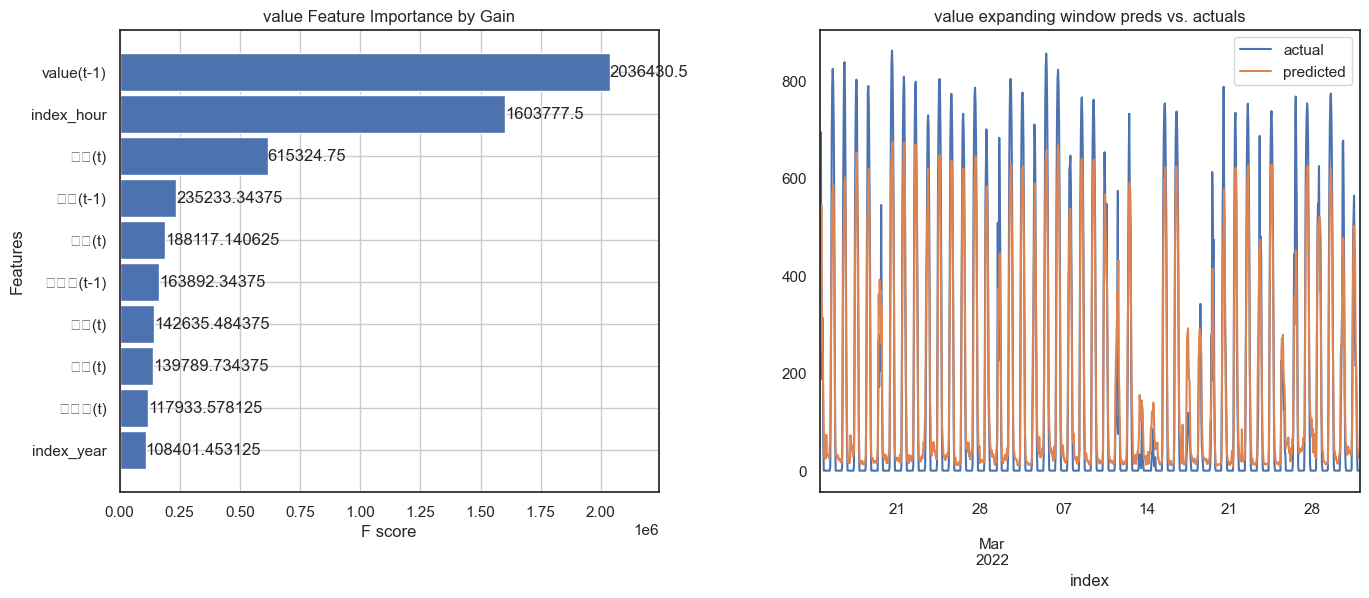

In [35]:
model.fit(
            traindata=time_data_train,
            ts_column='index',
            target='value',
            cv=5
        )

In [36]:
future_predictions = model.predict(
    testdata = time_data_test,
    model='best',
)

Predicting using test dataframe as input for Prophet model
Building Forecast dataframe. Forecast Period = 720


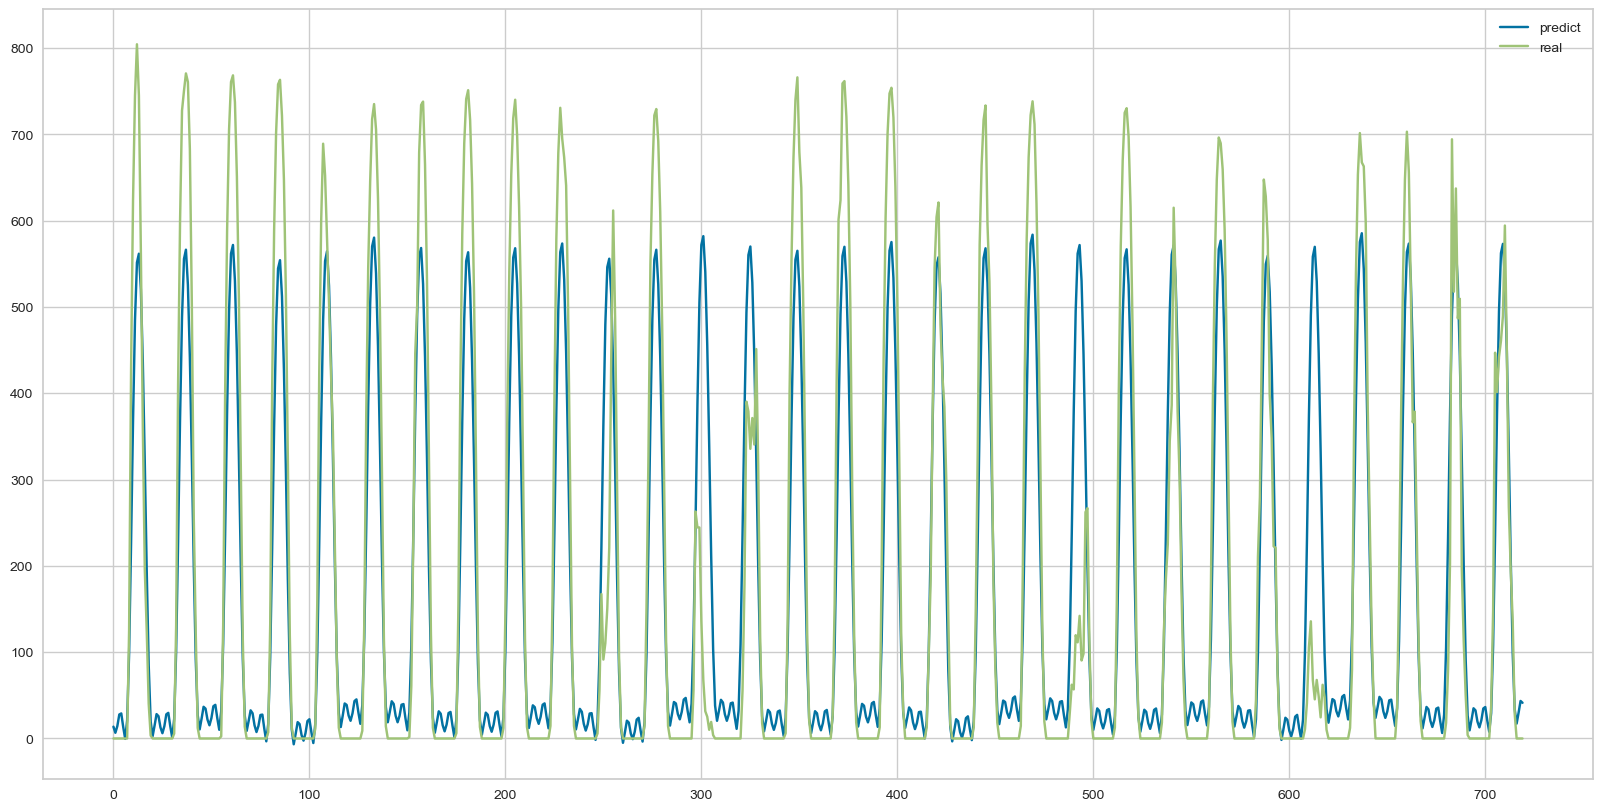

In [57]:
plt.figure(figsize=(20,10))
plt.plot(future_predictions.yhat)
plt.plot(sc_y.inverse_transform(y_test))
plt.legend(['predict', 'real'])
plt.show()

In [39]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [40]:
print('mse error (linear regression) : ',mean_squared_error(sc_y.inverse_transform(y_test), future_predictions.yhat))
print('mae error (linear regression) : ',mean_absolute_error(sc_y.inverse_transform(y_test), future_predictions.yhat))
print('mape error (linear regression) : ',mean_absolute_percentage_error(sc_y.inverse_transform(y_test), future_predictions.yhat))

mse error (linear regression) :  13534.365742105432
mae error (linear regression) :  75.23136044776315
mape error (linear regression) :  4.982364731427106e+16


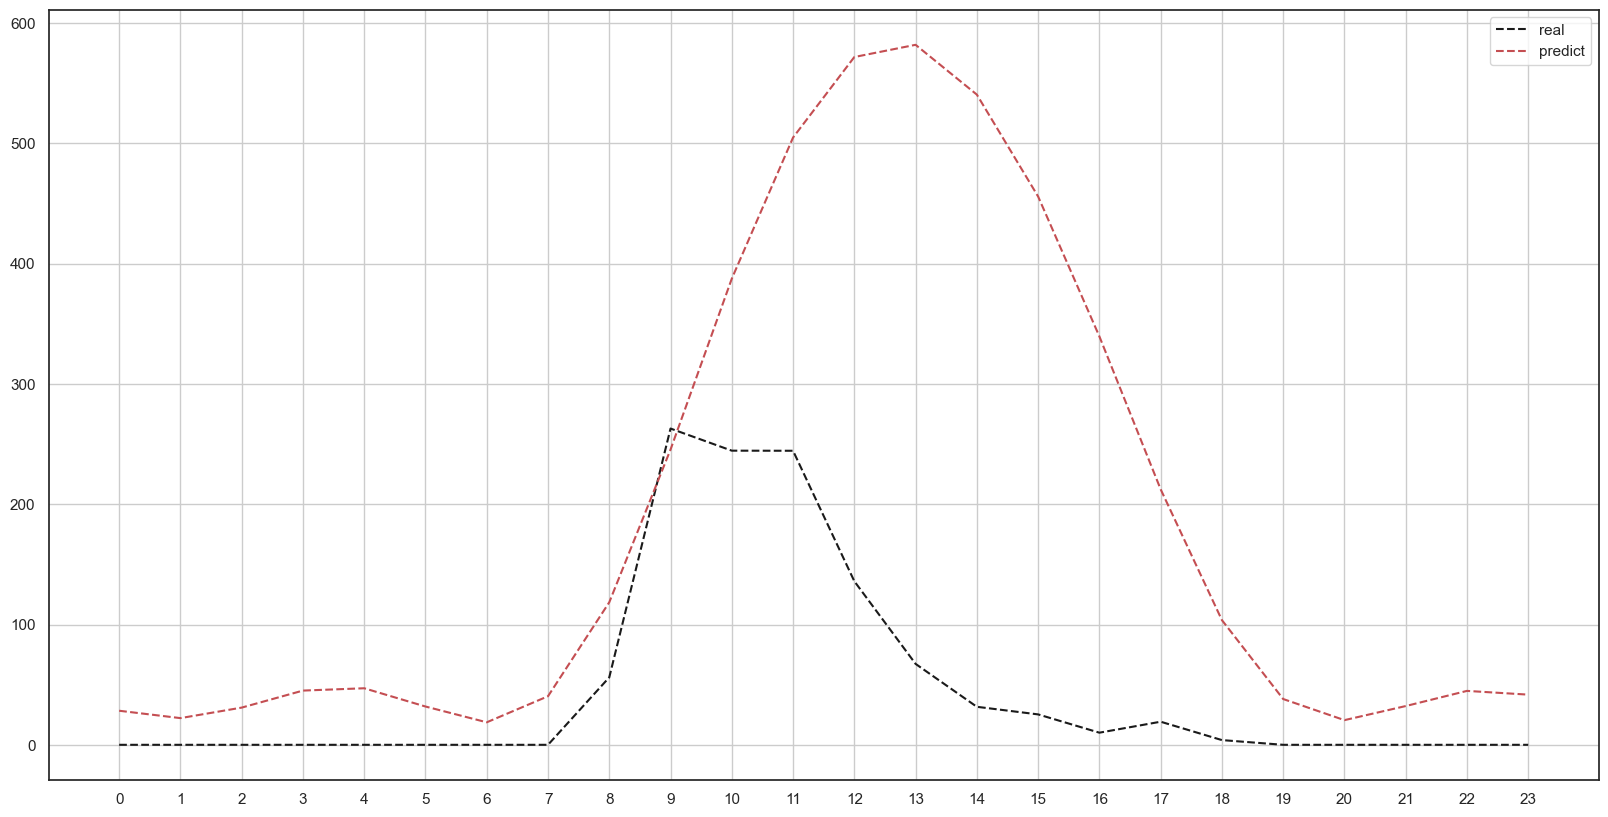

In [41]:
i = 12
plt.figure(figsize=(20,10))
plt.plot(np.arange(24), sc_y.inverse_transform(y_test)[i * 24 : 24*(i+1)], 'k--')
plt.plot(np.arange(24), future_predictions.yhat[i * 24 : 24*(i+1)], 'r--')


plt.legend(['real','predict'])
plt.xticks(np.arange(24))
plt.grid()
plt.show()

----
# AutoML

In [42]:
from pycaret.regression import *

In [43]:
time_data

,index,기온,풍속,풍향,습도,강수량,value
0,2021-01-01 00:00:00,-2.3,3.8,290.0,81.0,0.0,0.0
1,2021-01-01 01:00:00,-3.1,3.3,290.0,71.0,0.0,0.0
2,2021-01-01 02:00:00,-3.7,3.6,290.0,73.0,0.0,0.0
3,2021-01-01 03:00:00,-4.2,3.1,270.0,76.0,0.0,0.0
4,2021-01-01 04:00:00,-4.2,2.4,270.0,76.0,0.0,0.0
...,...,...,...,...,...,...,...
11635,2022-04-30 19:00:00,13.9,3.0,290.0,70.0,0.0,28.8
11636,2022-04-30 20:00:00,12.9,2.2,290.0,78.0,0.0,0.0
11637,2022-04-30 21:00:00,12.5,2.5,290.0,78.0,0.0,0.0
11638,2022-04-30 22:00:00,11.9,2.7,290.0,82.0,0.0,0.0


In [50]:
setup(data = time_data, target = 'value', normalize = True, normalize_method = 'zscore')

,Description,Value
0,Session id,2967
1,Target,value
2,Target type,Regression
3,Original data shape,"(11640, 7)"
4,Transformed data shape,"(11640, 9)"
5,Transformed train set shape,"(8147, 9)"
6,Transformed test set shape,"(3493, 9)"
7,Numeric features,5
8,Date features,1
9,Preprocess,True


In [51]:
model_test = compare_models(sort = 'MSE', n_select=10)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,96.7544,22095.8670,148.5468,0.6075,2.6229,8.9410,1.2300
et,Extra Trees Regressor,99.4575,23187.9857,152.1753,0.5881,2.6077,9.4741,1.2680
rf,Random Forest Regressor,101.0592,23666.4241,153.7451,0.5796,2.6571,9.1932,1.3960
xgboost,Extreme Gradient Boosting,100.4150,23915.2881,154.5734,0.5750,2.6692,9.3374,1.1640
gbr,Gradient Boosting Regressor,107.5752,25293.4400,158.9393,0.5508,2.7847,9.6455,1.1980
knn,K Neighbors Regressor,98.1245,25301.4139,158.9615,0.5504,2.3949,10.2994,1.1260
br,Bayesian Ridge,135.0510,31272.2033,176.7814,0.4441,3.2625,12.8803,1.1360
ridge,Ridge Regression,135.0484,31272.2702,176.7816,0.4441,3.2626,12.8796,1.1310
lar,Least Angle Regression,135.0482,31272.2872,176.7816,0.4441,3.2626,12.8795,1.1340
lr,Linear Regression,135.0482,31272.2872,176.7816,0.4441,3.2626,12.8795,1.5200


In [52]:
model_results = pull()

In [53]:
model_test

[LGBMRegressor(random_state=2967),
 ExtraTreesRegressor(n_jobs=-1, random_state=2967),
 RandomForestRegressor(n_jobs=-1, random_state=2967),
 XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=2967, ...),
 GradientBoostingRegressor(random_state=2967),
 KNeighborsRegressor(n_jobs=-1),
 BayesianRidge(),


lgbr = create_model('lightgbm')
rf = create_model('rf')
extra = create_model('et')
gradient = create_model('gbr')